# CS5014 Practical 2 
##### Unsupervised learning and EM algorithm (Due date: 28 March 2022; MMS is the definite source for deadlines and weightings.)
##### 60% of the coursework grade

## Set-up

Load required packages (you can only use the imported packages).

In [1]:
# if you use jupyter-lab, switch to %matplotlib inline instead
# %matplotlib inline
%matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.special import logsumexp
import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from vmf import VonMisesFisher

Set a random generator with a fixed seed to have roughly the same result everytime

In [2]:
# use fixed random number generator seed to have reproducible results
random_seed = 123
rng = np.random.default_rng(random_seed)

Read in dataset1:
* ``dataset1``: 500 observations and each with 4 features
* note that no cluster labels given for this dataset

In [3]:
# read in dataset1
d1_df = pd.read_csv('./datasets/dataset1.csv', header=None)
dataset1 = np.array(d1_df)
# it should contain 500 observations and each with 4 dimensional input
n_dataset1, d_dataset1 = dataset1.shape

In [4]:
n_dataset1

500

Read in dataset2, which contains 
* ``dataset2``: 500 observations; and each with 3000 features
* ``dataset2_labels``: the labels are listed in the last column; there are $K=4$ clusters

In [5]:
# read in dataset2
d2_df = pd.read_csv('./datasets/dataset2.csv', header=None)
dataset2, dataset2_labels = d2_df.iloc[:, 0:-1], d2_df.iloc[:, -1]
dataset2 = np.array(dataset2)
dataset2_labels = np.array(dataset2_labels).astype(int)
n_dataset2, d_dataset2 = dataset2.shape

In [6]:
n_dataset2

500

A quick demonstration of clustering performance evaluation
* use Sklearn.KMeans to fit a basic clustering model and 
* evaluate the clustering performance against the true label with normalised mutual information (NMI)

In [7]:
# evaluate clustering performance by normalised mutual information.
# use Kmeans to learn the clusters: use the first four rows as centroids
km_dataset2 = KMeans(n_clusters=4, init=dataset2[0:4,:]).fit(dataset2)
# should expect approximately < 0.35 performance by using Kmeans
normalized_mutual_info_score(km_dataset2.labels_, dataset2_labels)

/cs/home/yd42/CS5014/python/lib64/python3.6/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


0.30872980833029307

## Task 1. Spherical K-means

The first task is to implement a variant of K-means algorithm, which is called *Spherical K-means*. The algorithm follows a similar procedure as K-means but with slightly different assignment and update steps. In the following, we will explain the spherical K-means algorithm. 


**Initialisation step**: Start with randomly selecting $K$ data points as the centroid of $K$ clusters. 

**Assignment step**: *Spherical K-means* assigns a data point to the closest centroid based on *cosine distance* rather than Euclidean distance; specifically, for $i=1,\ldots, n$

$$z_i \leftarrow \arg\min_{k} \left (1- \frac{\mu_k^\top x_i }{\|\mu_k\| \cdot \|x_i\|}\right ),$$ where $\mu_k^\top x_i = \sum_{j=1}^d \mu_{kj} \cdot x_{ij}$ denotes the inner product and $\|x\|$ is $L_2$ norm of a vector $x$: $\|x\| = \sqrt{x^\top x}$.

**Update step**: *Spherical K-means* updates the centroids such that they are unit one vectors; for $k=1,\ldots, K$

$$\mu_k \leftarrow \frac{\sum_{i=1}^n I(z_i =k) \cdot x_i}{\|\sum_{i=1}^n I(z_i =k) \cdot x_i\|}.$$ Note that after the normalisation step, the centroids $\mu_k$ are norm-one vectors: i.e. $\|\mu_k\| = 1$ for $k=1,\ldots, K$.

**Repeat** the above two steps **until** the total cosine distance loss, defined as
$$\texttt{loss} = \sum_{i=1}^n \left (1- \frac{\mu_{z_i}^\top x_i }{\|\mu_{z_i}\| \cdot \|x_i\|}\right )$$ converges.



#### Task 1.1 Implementation of Spherical K-means

Your task is to complete the code for *assignment* and *update* steps at the given code template of `sphericalKmeans`.

The method `sphericalKmeans` has

**Inputs**:
* `data`: a $n\times d$ matrix to cluster, i.e. each row of $\texttt{data}$ is one observation $x_i$
* `K`: the number of the clusters
* `tol`: tolerence of error, which is used to check whether the loss has converged so the iteration can stop
* `maxIters`: the maximum number of iterations that is allowed

**Outputs**:
* `losses`: the whole trajectory of losses over the iterations
* `zs`: the clustering labels
* `us`: the learnt $K$ centroids

Feel free to write extra helper methods to make your implementation modularised. You may also rewrite the method altogether as long as your method respect the given mtehod's input/output signature. 

In [8]:
def sphericalKmeans(data, K=3, tol= 1e-4, maxIters= 100):
    n, d = data.shape 
    losses = []
    # initialisation: randomly assign K observations as centroids
    # feel free to use a different but sensible initialisation method    
    init_us_ids = rng.integers(n, size = K)
    us = data[init_us_ids, :]
    zs = np.zeros(n)
    # loop until converge 
    for num in range(maxIters):
        # assignment step
        for i in range(n):
            K_list=[]
            for k in range(K):
                numerator =  us[k].transpose()@data[i,:]
                xi_val=np.linalg.norm(data[i,:])
                us_val=np.linalg.norm(us[k,:])
                denominator = (us_val*xi_val)
                val_k = 1 - (numerator/denominator)
                K_list.append(val_k)
            zi = np.argmin(K_list)
            zs[i]=zi
            
        # update step
        arr=np.zeros((n, d), dtype=float)
        for k in range(K):
            Ik=[]
            for i in range(n):
                if zs[i]==k:
                    Ik.append(1)
                else:
                    Ik.append(0)
            for i in range(n):
                arr[i]=data[i,:]*Ik[i]
            up = np.sum(arr,axis=0)
            down = np.linalg.norm(up)
            us[k]=up/down
            
        # convergence check       
        loss=0
        for i in range(n):
            up=(us[int(zs[i])].transpose()@ data[i,:])
            down=(np.linalg.norm(us[int(zs[i])])) * (np.linalg.norm(data[i,:]))
            loss=loss+(1-up/down)
        if len(losses)>0:
            if abs(loss-losses[-1]) < tol:
                break
            else:
                losses.append(loss)
        else:
            losses.append(loss)
    return losses, zs, us

#### Task 1.2 Evaluation

Run your implemented algorithm on `dataset1` with $K =3$. Note that like K-means, Spherical K-means also suffers from bad initialisations. To deal with that, we usually run the algorithm multiple times with different random initialisations. To make your life easier, you may want to write a wrapper method that does it automatically.

Please report the following information based on your results: 
* the learned 3 centroids
* and also plot the loss trajectory.

If you run multiple times, you only need to report the results for the best one.

<IPython.core.display.Javascript object>


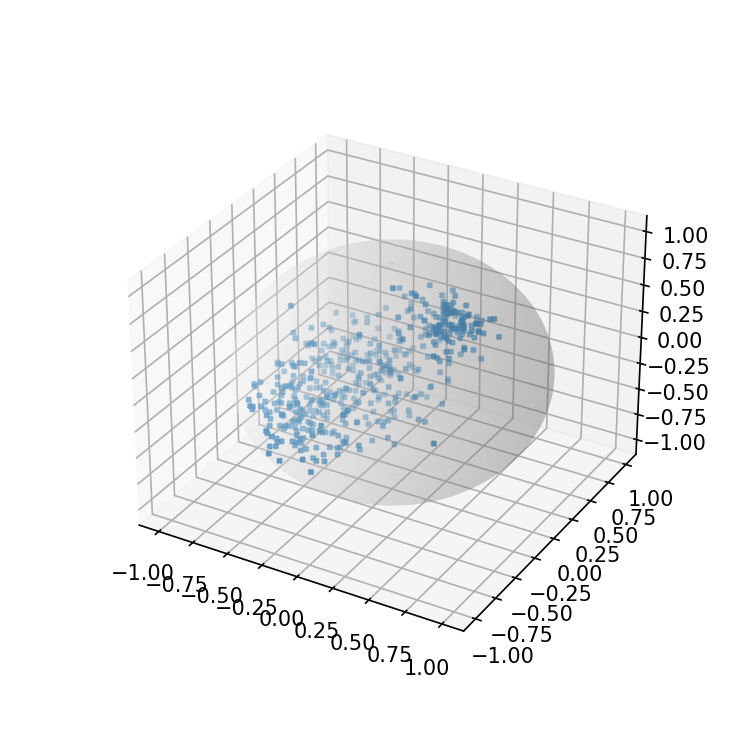

In [9]:
#Plot dataset1
plt.rcParams["figure.figsize"]=5,5
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# sphere coordinates representation of the sphere (for better presentation)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 80)
x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
# plot a sphere
ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='w', linewidth=0, alpha=0.2)
# plot the samples
ax.scatter(dataset1[:,0], dataset1[:,1], dataset1[:,2], marker ='x', s=5.0)
# ax.scatter(data_vmf2[:,0], data_vmf2[:,1], data_vmf2[:,2], s=5.0)
# ax.scatter(data_vmf3[:,0], data_vmf3[:,1], data_vmf3[:,2], s=5.0)

In [10]:
def plot_loss(losses):
    fig= plt.figure(figsize=(5,5))
    plt.xlabel("Number of Iteration")
    plt.ylabel("losses")
    plt.title("Loss Trajectory.")
    plt.plot(losses)

<IPython.core.display.Javascript object>


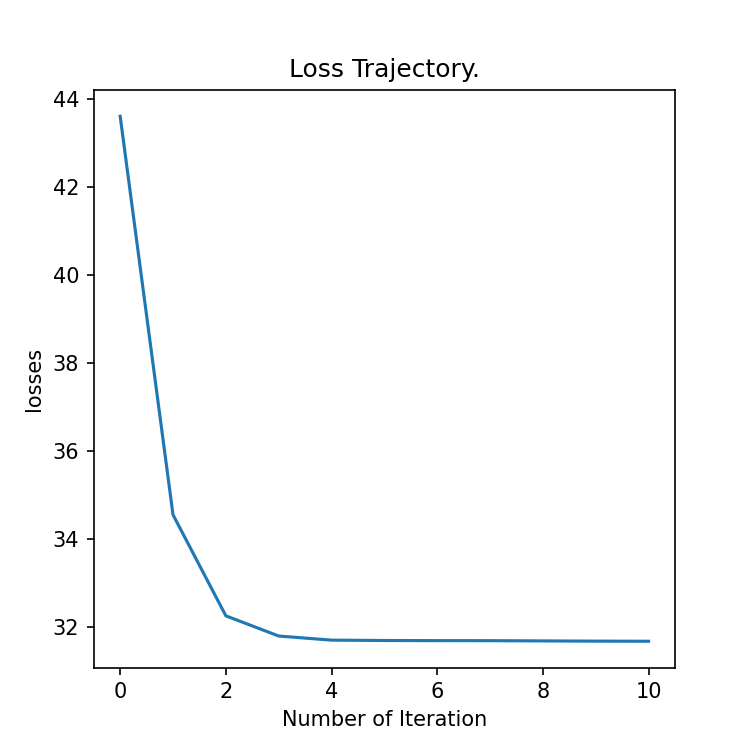

<IPython.core.display.Javascript object>


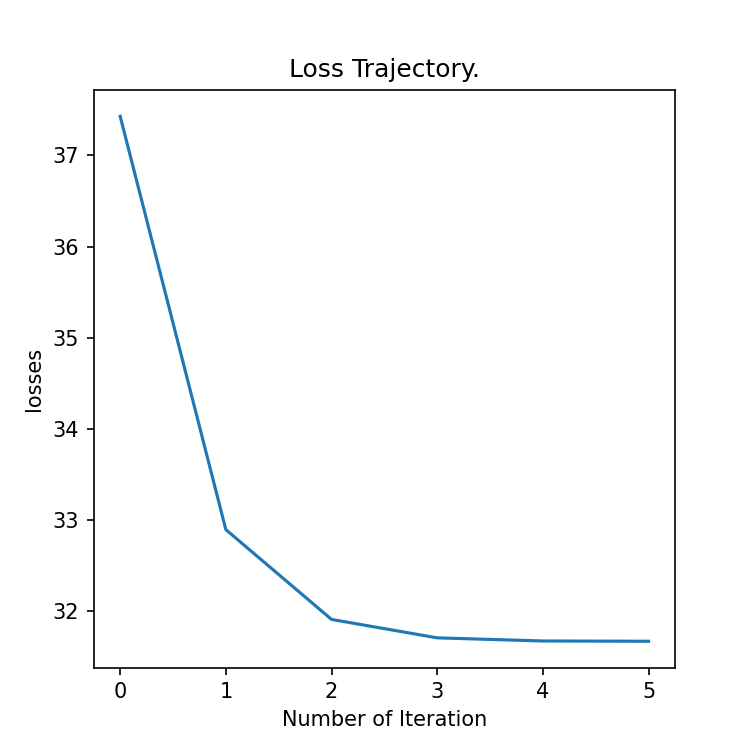

<IPython.core.display.Javascript object>


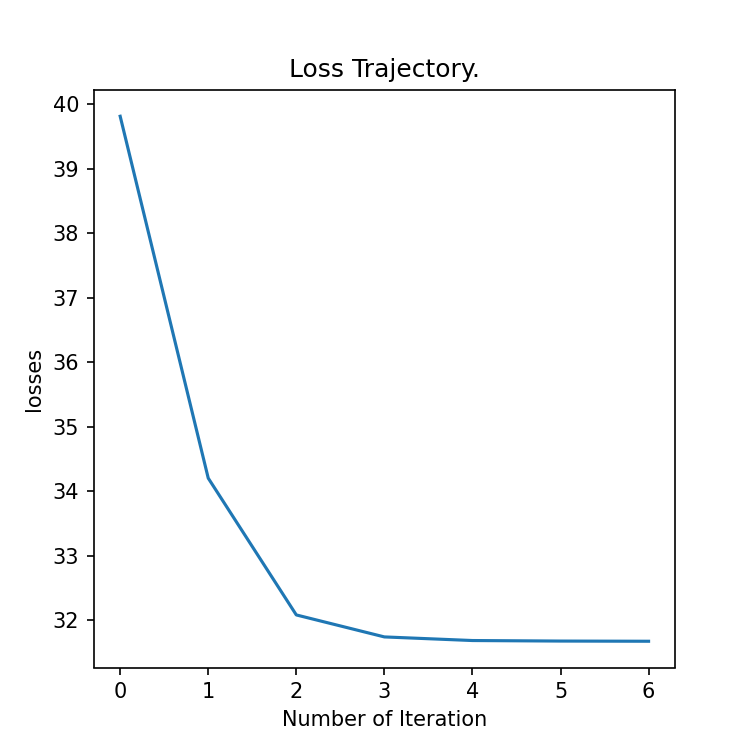

<IPython.core.display.Javascript object>


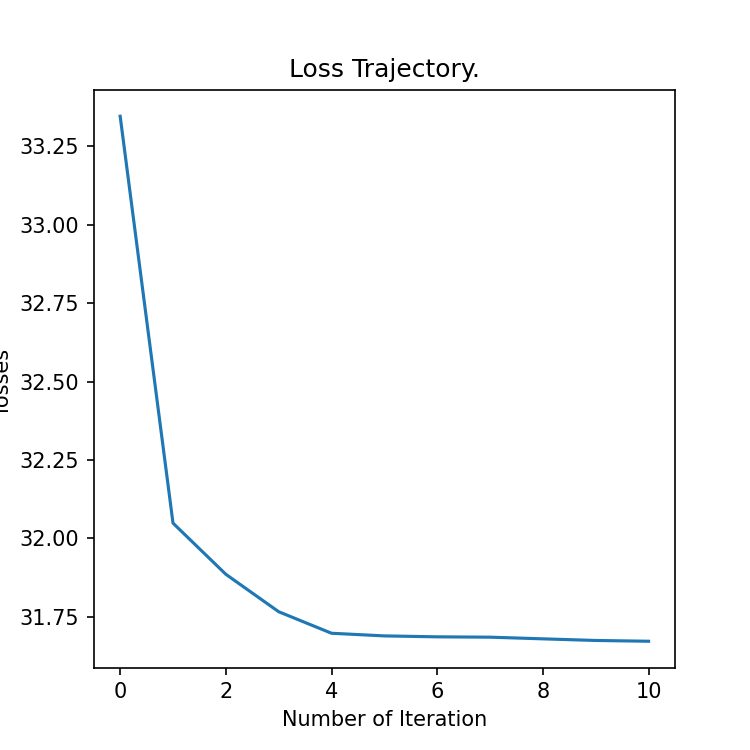

<IPython.core.display.Javascript object>


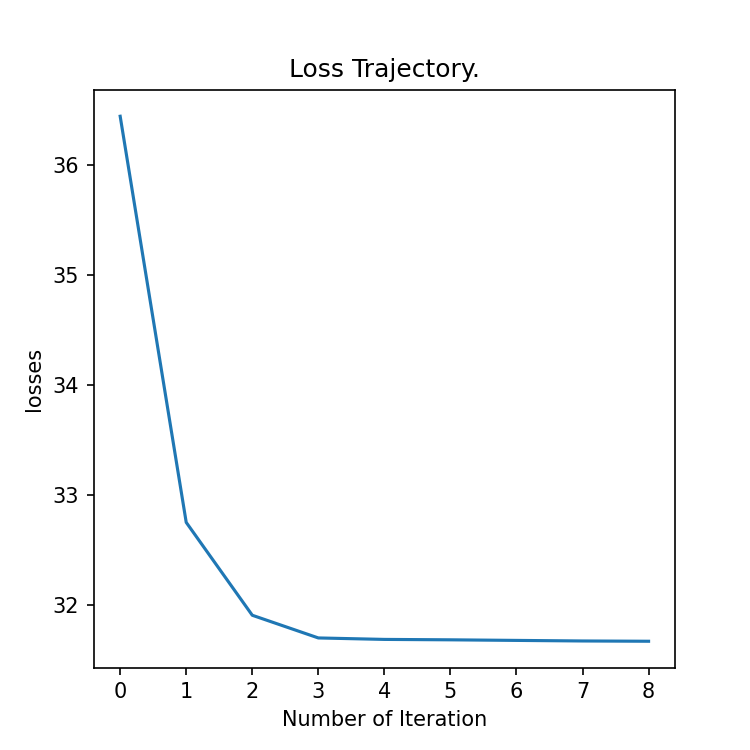

<IPython.core.display.Javascript object>


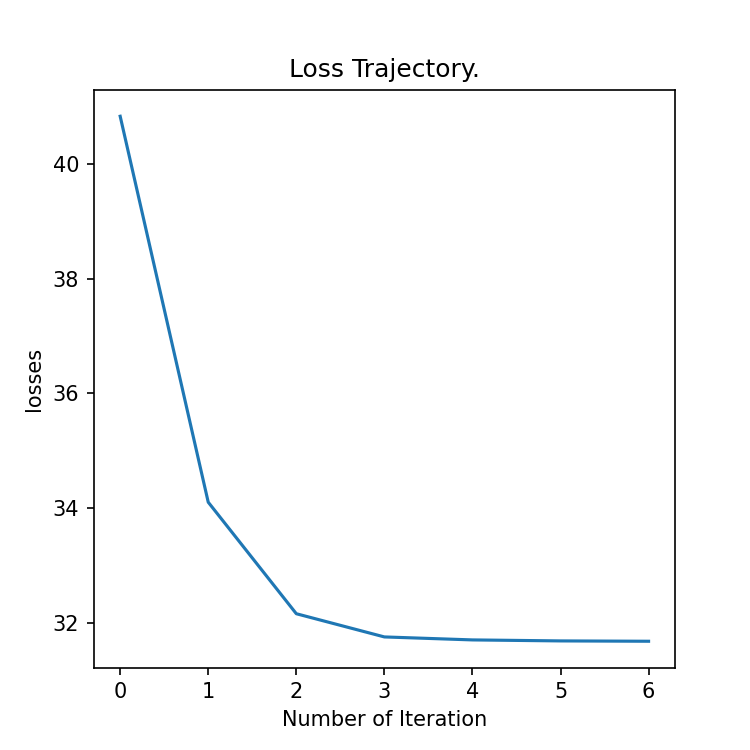

<IPython.core.display.Javascript object>


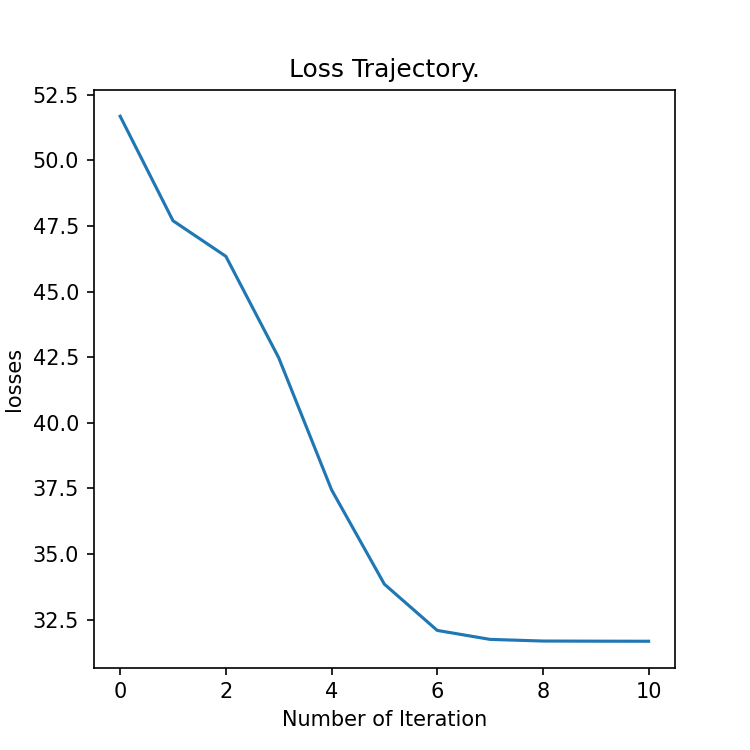

<IPython.core.display.Javascript object>


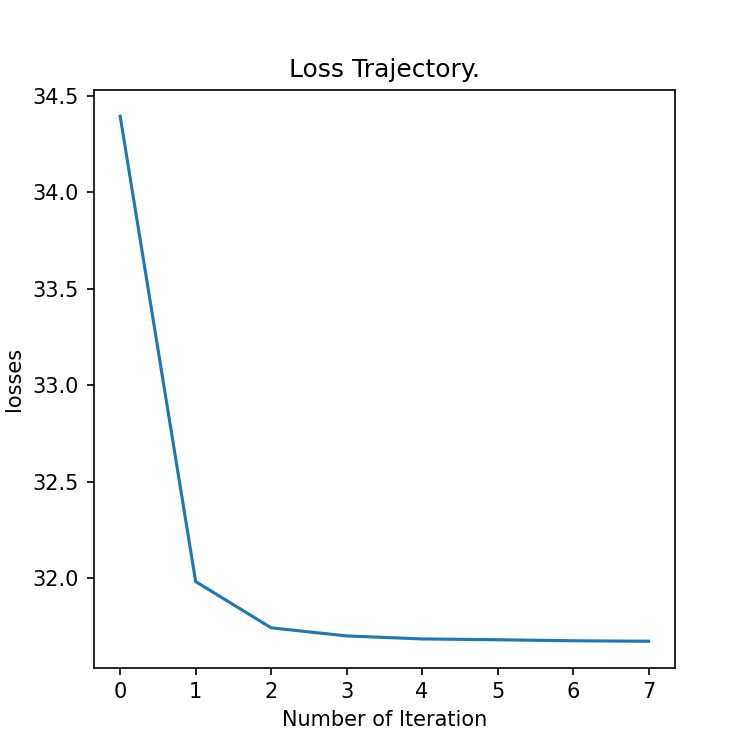

<IPython.core.display.Javascript object>


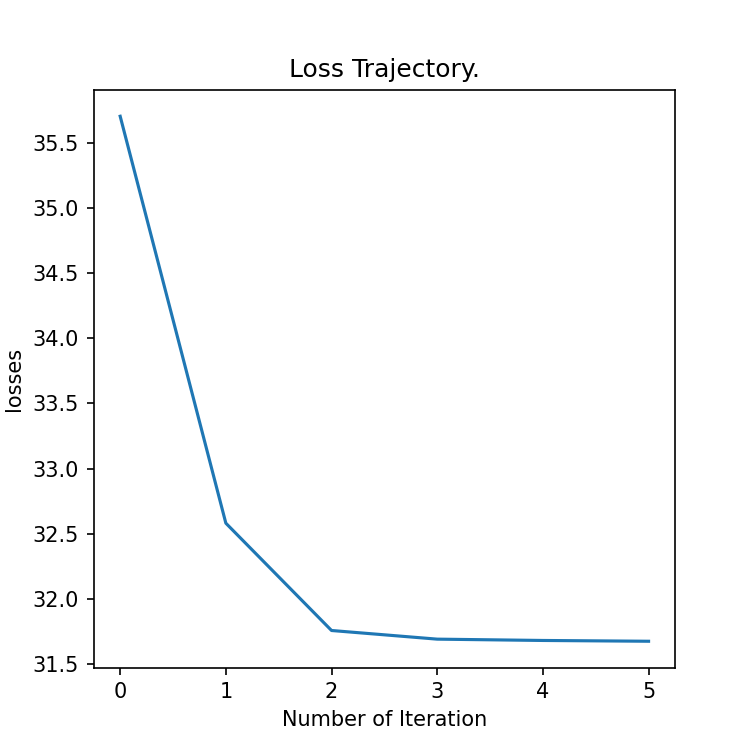

<IPython.core.display.Javascript object>


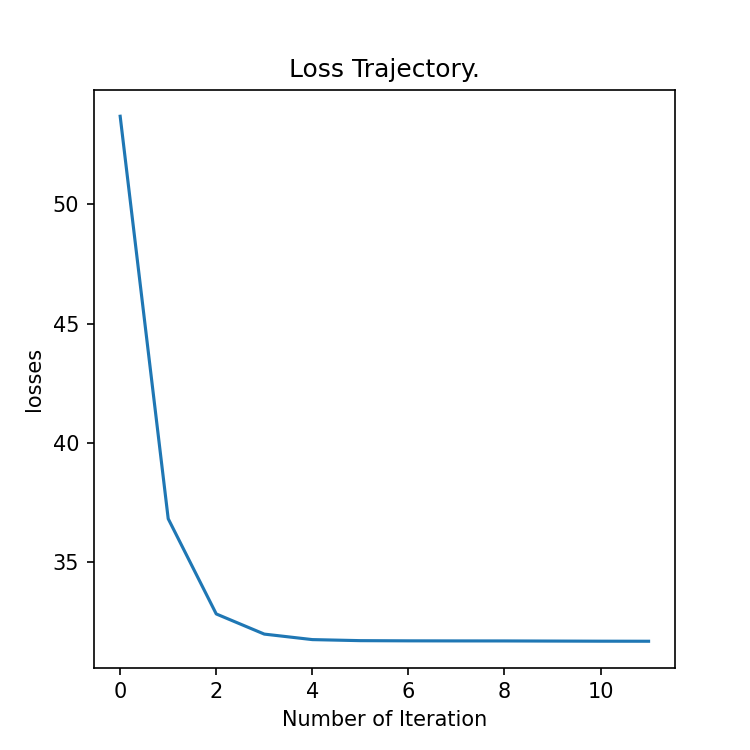

us_history
[[[-0.01647354  0.71315821 -0.024021    0.70039773]
  [-0.70282193  0.0007319  -0.71060402  0.03290485]
  [-0.50696813  0.49707684 -0.53749747  0.45496637]]

 [[-0.70180998  0.00302996 -0.71156038  0.03369567]
  [-0.01647354  0.71315821 -0.024021    0.70039773]
  [-0.50681396  0.4977044  -0.53574561  0.4565157 ]]

 [[-0.01647354  0.71315821 -0.024021    0.70039773]
  [-0.50681396  0.4977044  -0.53574561  0.4565157 ]
  [-0.70180998  0.00302996 -0.71156038  0.03369567]]

 [[-0.50696813  0.49707684 -0.53749747  0.45496637]
  [-0.70282193  0.0007319  -0.71060402  0.03290485]
  [-0.01647354  0.71315821 -0.024021    0.70039773]]

 [[-0.50696813  0.49707684 -0.53749747  0.45496637]
  [-0.70282193  0.0007319  -0.71060402  0.03290485]
  [-0.01647354  0.71315821 -0.024021    0.70039773]]

 [[-0.70180998  0.00302996 -0.71156038  0.03369567]
  [-0.01647354  0.71315821 -0.024021    0.70039773]
  [-0.50681396  0.4977044  -0.53574561  0.4565157 ]]

 [[-0.70180998  0.00302996 -0.71156038  0

In [11]:
# run spherical K-means on dataset1 and report your results here
# use more cells if you need to
iteration=10
us_history=[]
for i in range(iteration):
    
    losses, zs, us=sphericalKmeans(dataset1, K=3, tol= 1e-4, maxIters= 100)
    us_history.append(us.tolist())
    plot_loss(losses)

us_history=np.array(us_history)
print("us_history")
print(us_history)


Now run your implemented algorithm on `dataset2` with $K =4$. And report the normalised mutual information between the returned cluster labels and true labels.

In [14]:
# run spherical K-means on dataset2 and report your NMI results here
# use more cells if you need to
score=[]
for i in range(10):
    losses, zs, us=sphericalKmeans(dataset2, K=4, tol= 1e-4, maxIters= 100)
    score.append(normalized_mutual_info_score(zs, dataset2_labels))
print(np.mean(score))

0.14603140170116755


## Task 2: Fitting mixture of von Mises-Fisher

#### Background on von Mises-Fisher

In real world applications, datasets with very large dimensions, e.g. text and gene expression data, can be better modelled as directional vectors on a hypersphere rather than points in a Euclidean space. A probabilistic model that is suitable for this purpose is **von Mises-Fisher** distribution. In this task, we are going to implement a learning algorithm that can fit a finite mixture of von Mises-Fishers unsupervisedly. 

<img src="https://leo.host.cs.st-andrews.ac.uk/figs/CS5014/vmf.png" alt="Drawing" width="300"/>

Specifically, a vMF is a probability distribution over $d$-dimensional unit length vectors (i.e. $x \in R^d$ and $\|x\|=1$) and its probability density has the following functional form:
$$p(x|\mu, \kappa) = c_d(\kappa) \exp (\kappa \mu^\top x),$$
where 
* $\mu \in R^d$ and $\|\mu\|=1$, a unit length vector, is the mean direction of the distribution; 
* $\kappa > 0$ is the precision or concentration parameter that controls the spread of the distribution; larger concentration parameter $\kappa$ will make the distribution more concentratively clustered around the mean direction; 
* $c_d(\kappa)$ is the normalising constant such that the probability density integrates to one. 

Random samples from three different vMFs are shown in the figure above. The thick colored vectors mark their mean direction $\mu$s. And you can observe the effect of $\kappa$ directly. For example, the red vMF's spread is much smaller as it has a larger $\kappa$. Intuitively, you can think of vMF as an equivalence of Gaussian on hyperspheres rather than Euclidean space. The concentration parameter of vMF is just the inverse of the variance. 


It can be shown that the maximum likelihood estimators of vMF are

$$\mu_{ml} = \frac{\sum_{i=1}^n x_i}{\|\sum_{i=1}^n x_i\|},\;\; \kappa_{ml} \approx \frac{\bar r (d- \bar r^2)}{1- \bar r^2},$$

where $\bar r = \frac{\|\sum_{i=1}^n x_i\|}{n}$ is called *mean resultant length* in statistics community. And the **weighted maximum likelihood estimators** are

$$\tilde \mu_{ml} = \frac{\sum_{i=1}^n w_i x_i}{\|\sum_{i=1}^n w_i x_i\|},\;\; \tilde \kappa_{ml} \approx \frac{\tilde r (d- \tilde r^2)}{1- \tilde r^2},$$

where $\tilde r = \frac{\|\sum_{i=1}^n w_i x_i\|}{\sum_{i=1}^n w_i}$ is the weighted equivalence of the mean resultant length. And as expected, when you set $w_i=1$ for all $i$, we recover the normal MLE definition and also ML estimators. Note that the weighted ML estimators are defined as:
$$\tilde \mu_{ml}, \tilde \kappa_{ml} \leftarrow \arg\max_{\mu, \kappa} \sum_{i=1}^n w_i \log p(x_i|\mu, \kappa).$$ And recall what we have dicussed in Lecture 11 that weighted maximum likelihood estimation serves as the re-estimation step of an EM algorithm for a finite mixture model.


###### VonMisesFisher Class
A basic implementation of von Mises-Fisher in Python (`vmf.py` on studres) has provided for you. It has the following functionalities:
- instaniating a vMF instance with a given set of $\mu, \kappa$
- (log) density evaluation at one data input or a batch of data matrix (each row should be one observation), i.e. $\log p(x|\mu, \kappa)$
- randomly generate samples from a vMF

Check the following code snippets to familarise yourself with the class. The provided code should be enough for you to extend the model to finite mixture of vMFs, which is the core task of this practical.

1. Initialise 3 vMFs with $\mu_1 = [0, \frac{1}{\sqrt{2}}, -\frac{1}{\sqrt{2}}] , \kappa_1 = 5$; $\mu_2 = [-\frac{1}{\sqrt{2}}, 0, \frac{1}{\sqrt{2}}] , \kappa_2 = 10$ and $\mu_3 = [0, -\frac{1}{\sqrt{2}}, -\frac{1}{\sqrt{2}}] , \kappa_3 = 80$.

In [15]:
# to type μ: type \mu + tab; \kappa + tab for κ 
μs = np.array([[0,1/np.sqrt(2),-1/np.sqrt(2)], [-1/np.sqrt(2),0,1/np.sqrt(2)], [0,-1/np.sqrt(2),- 1/np.sqrt(2)]])
κs = np.array([5, 10, 80])
# initialise three vMFs with three different parameters
# use the random generator rng with a fixed seed to ensure reproduciability
vmf1= VonMisesFisher(μs[0,:], κs[0], rng)
vmf2= VonMisesFisher(μs[1,:], κs[1], rng)
vmf3= VonMisesFisher(μs[2,:], κs[2], rng)

2. Random sampling from vMFs and density evaluation

In [16]:
# random sample 300, 100, 100 from the vMFs 
data_vmf1 = vmf1.sample(300)
data_vmf2 = vmf2.sample(100)
data_vmf3 = vmf3.sample(100)
# note that when you sample one observation, vmf.sample(1) still returns a 1 by d matrix
# you can transform it to an array e.g. by np.squeeze(vmf.sample(1))
# evaluate the density at those random samples
# logLiks_ is a 300 by 1 vector contains the log likelihood of vMF 1 evaluated at data_vmf1 
logLiks_ = vmf1.logpdf(data_vmf1)

3. You may want to visualise the samples (you can rotate the figure to see it better)
  * note the effect of $\kappa$: larger $\kappa$ leads to more concentrated samples

<IPython.core.display.Javascript object>


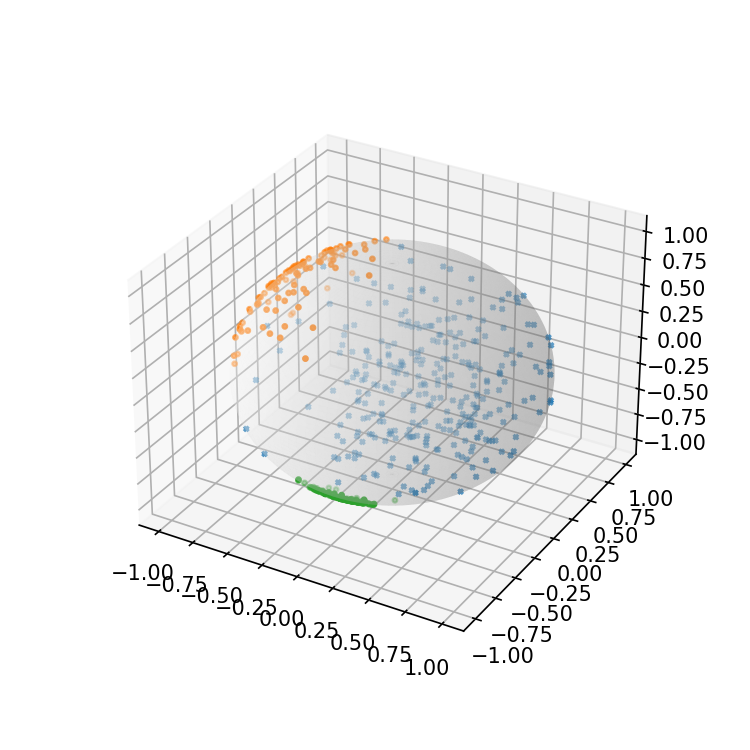

In [17]:
plt.rcParams["figure.figsize"]=5,5
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# sphere coordinates representation of the sphere (for better presentation)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 80)
x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
# plot a sphere
ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='w', linewidth=0, alpha=0.2)
# plot the samples
ax.scatter(data_vmf1[:,0], data_vmf1[:,1], data_vmf1[:,2], marker ='x', s=5.0)
ax.scatter(data_vmf2[:,0], data_vmf2[:,1], data_vmf2[:,2], s=5.0)
ax.scatter(data_vmf3[:,0], data_vmf3[:,1], data_vmf3[:,2], s=5.0)

#### Task 2.1 randomly sample from a finite mixture of vMFs

Firstly, write a method that randomly generates samples from a finite mixture of vMFs. Recall the definition of a finite mixture model is 
$$p(x) = \sum_{k=1}^K \pi_k p(x| \mu_k, \kappa_k).$$

The method should have
**input** 
* `πs`: the prior mixture proportion $\pi_k$ for $k=1,\ldots, K$;
* `μs, κs`: $K$ set of vMF's parameters;
* `n`: number of samples to generate

and **output**
* `samples`: the gererated samples, should be a n by d matrix
* `zs`: the true cluster labels, where each $z_i \in 1, 2\ldots, K$ is the index of the cluster that has generated the i-th sample.



Once you have done so, use the implemented method to sample `n=500` samples from a ($K=3$) mixture of vMFs with following parameters:
* $\pi = [0.4, 0.3, 0.3]$
* $\mu_1 = [0, \frac{1}{\sqrt{2}}, -\frac{1}{\sqrt{2}}] , \kappa_1 = 10$; $\mu_2 = [-\frac{1}{\sqrt{2}}, 0, \frac{1}{\sqrt{2}}] , \kappa_2 = 25$$; $$\mu_3 = [0, -\frac{1}{\sqrt{2}}, -\frac{1}{\sqrt{2}}] , \kappa_3 = 50$

In [18]:
def plot_mixGaussian_data(data, zs, title=""):
    plt.figure()
    plt.title(title)
    for k in np.unique(zs):
        fig = plt.scatter(data[zs==k,0], data[zs==k,1], marker='.')
    fig.axes.set_aspect(1)
    return(fig)

In [19]:
# rng: a random number generator
def sample_mix_vmfs(πs, μs, κs, n, rng):
    K, dim = μs.shape
    samples = np.zeros((n,dim))
    zs = rng.choice(K, n, p=πs)
    # fill the missing steps here !
    for i in range(n):
        samples[i,:] = VonMisesFisher(μs[zs[i],: ], κs[zs[i]] ,rng).sample(1)
    return samples, zs

# to type μ: type \mu + tab; \kappa + tab for κ 
trueπs = np.array([0.4, 0.3, 0.3])
trueμs = np.array([[0,1/np.sqrt(2),-1/np.sqrt(2)], [-1/np.sqrt(2),0,1/np.sqrt(2)], [0,-1/np.sqrt(2),- 1/np.sqrt(2)]])
trueκs = np.array([10, 25, 50])
n_size = 500
# use the random generator rng with a fixed seed
simData, simData_labels = sample_mix_vmfs(trueπs, trueμs, trueκs, n_size, rng)
# plot_mixGaussian_data(simData, simData_labels, "")

<IPython.core.display.Javascript object>


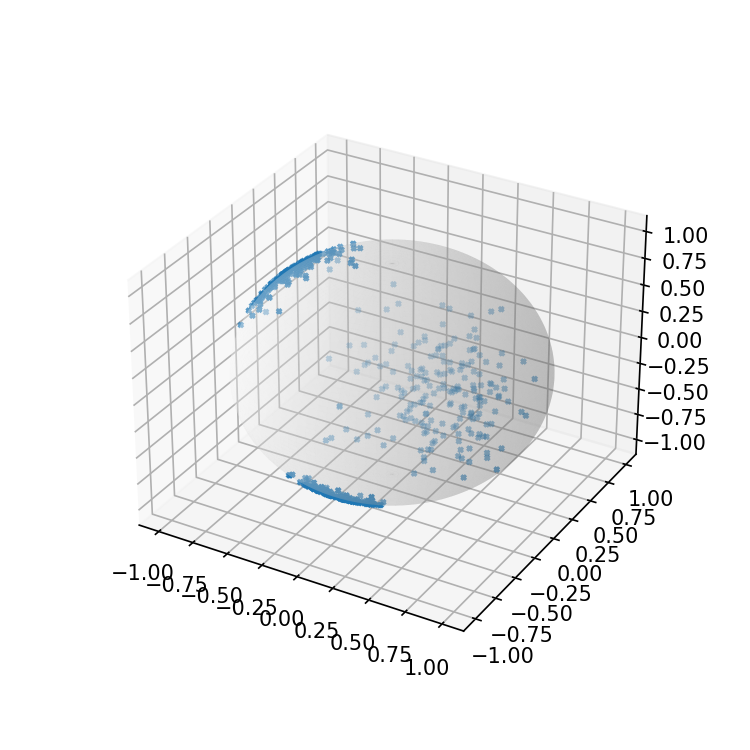

In [20]:
#plot SimData
plt.rcParams["figure.figsize"]=5,5
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# sphere coordinates representation of the sphere (for better presentation)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 80)
x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
# plot a sphere
ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='w', linewidth=0, alpha=0.2)
# plot the samples
ax.scatter(simData[:,0], simData[:,1], simData[:,2], marker ='x', s=5.0)

#### Task 2.2 EM algorithm for mixture of vMFs

Implement an EM algorithm that can learn the parameters of finite mixture of vMFs. To achieve full mark on this task, you need to implement both
* EM algorithm with a soft E step (soft-EM)
* EM algorithm with a hard E step (hard-EM)

The method takes similar input as `sphericalKmeans` but it should output
* `logLiks`: the trajectory of the (log)-likelihood
* `πs, μs, κs`: the learnt parameters of the finite mixture model
* `zs`: the assigned clusters of the observations

Hint: it would be easier if you decompose the algorithm into E step (``estep`` with option of being soft `"s"` or hard `"h"` expectation step) and M step. Implement and test them independently and then combine them together to form a complete EM algorithm.

In [120]:
def e_step(data, πs, μs, κs, estep):
#     print("estep")
    n, d = data.shape
    K = len(πs)
    # fill the missing steps here 
    liks = np.array([VonMisesFisher.logpdf(VonMisesFisher(μs[k,: ], κs[k],rng),data) for k in range(K)]).transpose()
    log_post = np.log(πs) + liks
    log_sumPost=logsumexp(log_post,axis=1)
    logLik = np.sum(log_sumPost)

    if estep =="s":
        s=log_post-log_sumPost[:,None]
        ws=np.exp(s)
        return ws, logLik
    elif estep =="h":
        zs_ = np.argmax(log_post, axis=1)
        zs = np.eye(K)[zs_,:]
        # you need to think what to return here    
        return zs_, logLik

In [121]:
# you need to think what inputs are required for the M step
def m_step(data,ws):
   
    # fill the missing steps here
    n= data.shape[0]
    d = data.shape[1]
    K = ws.shape[1]

    # get πs
    ns=np.sum(ws,axis=0)
    πs = ns/n

    # get μs
    up = data.transpose() @ ws
    down = np.linalg.norm(up,axis=0)
    μs=(up/down).transpose()

    # get κs
    rs = (down/ns)
    κs=[]
    for k in range(K):
        ki=(rs[k]*(d-rs[k]**2))/(1-rs[k]**2)
        κs.append(ki)
        κs=np.array(κs)
        #cap ks value
        κs = np.clip(κs,1.0e-1,1.0e+4)
        κs=κs.tolist()
    return πs, μs, κs

In [122]:
def em_mix_vmfs(data, K=3, estep="s", tol= 1e-4, maxIters= 100):
    # initialisation here
    # zs is the final clustering results  
    d = data.shape[1]
    n = data.shape[0]
    z_init = rng.integers(K, size=n)
    ws = np.eye(K)[z_init]
    pis_history = []
    mus_history = []
    ks_history= []
    logLiks_history = []
    
    # loop until converge  
    for i in range(maxIters):
        #  E-step or M-step first then E-step 
        pis, mus, ks = m_step(data, ws)
        #  M-step 
        ws,logLik = e_step(data, pis, mus, ks, estep="s")
        zs_, _ = e_step(data, pis, mus, ks, estep="h")
        pis_history.append(pis.tolist())
        mus_history.append(mus.tolist())
        ks_history.append(ks)
        logLiks_history.append(logLik)
        
        if i > 2:
            if abs(logLiks_history[-1]-logLiks_history[-2]) < tol:
                break
    pis_history=np.array(pis_history)
    mus_history=np.array(mus_history)
    ks_history = np.array(ks_history)
    return logLiks_history, pis_history, mus_history, ks_history, zs_

#### Task 2.3 Test your algorithm on simulated dataset of Task 2.1

The objective of this task is to test whether your algorithm works by using a simulated dataset with known ground truth. Again, you may need to repeat the algorithm a few times with different random initialisations to avoid bad initialisations. Run your EM algorithm on the dataset simulated in task 2.1. You need to show:
* whether your algorithm can recover the true parameters when correct $K=3$ is given ? 
* plot the (log)Likelihood trajectory

Report your results below.

In [123]:
def plot_logLik(logLik):
    fig= plt.figure(figsize=(5,5))
    plt.xlabel("Number Of Iteration")
    plt.ylabel("Log Likelihood")
    plt.title("Log Likelihood")
    plt.plot(logLik)

score 1.0


<IPython.core.display.Javascript object>


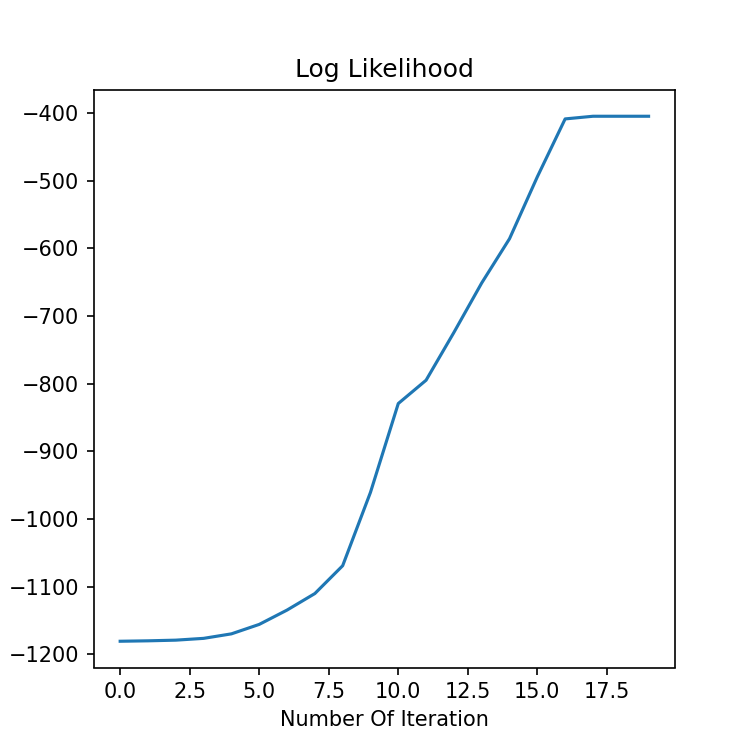

In [127]:
# run your algorithm and report results here
logLik,pis_history, mus_history, ks_history, zs=em_mix_vmfs(simData,K=3,estep="s")

print("score",normalized_mutual_info_score(zs, simData_labels))
plot_logLik(logLik)

#### Task 2.4 Evaluation on given datasets

Now run your EM algorithms (both soft and hard if you have implemented both) on `dataset1` with $K=3$. As no labels are given, you only need to report the estimated $\mu_k$,$\kappa_k$ for $k=1,\ldots, K$ and $\pi$.

In [125]:
# run your algorithm on dataset 1 and report results here
logLik, pis_history, mus_history, ks_history, zs=em_mix_vmfs(dataset1, K=3, estep="s", tol= 1e-4, maxIters=100)
print("Pi History: ")
print(pis_history)
print("Mus History: ")
print(mus_history)
print("Mus ks_history: ")
print(ks_history)

Pi History: 
[[0.312      0.336      0.352     ]
 [0.31051143 0.33645645 0.35303212]
 [0.31054616 0.33517048 0.35428337]
 [0.31602866 0.32578506 0.35818628]
 [0.34078454 0.28609252 0.37312293]
 [0.37986722 0.22807787 0.39205491]
 [0.38571395 0.24294173 0.37134432]
 [0.36921135 0.29524237 0.33554628]
 [0.35129037 0.34100366 0.30770596]
 [0.33692002 0.37153545 0.29154453]
 [0.32516649 0.39098456 0.28384895]
 [0.31555461 0.40387518 0.28057021]
 [0.30782395 0.41286446 0.27931159]
 [0.30167853 0.41940037 0.2789211 ]
 [0.29682766 0.42429011 0.27888222]
 [0.29301471 0.42801445 0.27897083]
 [0.29002564 0.43088128 0.27909308]
 [0.28768683 0.43310099 0.27921218]
 [0.28585942 0.43482488 0.2793157 ]
 [0.28443315 0.43616561 0.27940123]
 [0.28332093 0.43720896 0.2794701 ]
 [0.2824542  0.43802101 0.27952479]
 [0.28177912 0.438653   0.27956788]
 [0.28125354 0.4391448  0.27960166]
 [0.28084449 0.43952743 0.27962808]
 [0.2805262  0.4398251  0.2796487 ]
 [0.28027859 0.44005663 0.27966478]
 [0.28008599 0.

Run your EM algorithm on `dataset2` with $K=4$ and report the NMI performance. Compare the clustering performance with Sperical K-means and present the comparison result in a suitable format (e.g. table or figure).

In [166]:
# run your algorithm on dataset 2 and compare with spherical K-means
score=[]

for iteration in range(10):
    logLik, pis_history, mus_history, ks_history, zs=em_mix_vmfs(dataset2, K=4, estep="s", tol= 1e-4, maxIters=100)
    nmi=normalized_mutual_info_score(zs, dataset2_labels)
#         print(nmi)
    score.append(nmi)

print(np.mean(score))

0.41053561967201807


In [168]:
# run spherical K-means on dataset2 and report your NMI results here
# use more cells if you need to
score=[]
for i in range(10):
    losses, zs, us=sphericalKmeans(dataset2, K=4, tol= 1e-4, maxIters= 100)
    score.append(normalized_mutual_info_score(zs, dataset2_labels))
print(np.mean(score))

0.17966792467023102


## Task 3: Advanced Tasks (incremental EM)

For datasets with enormous amount of observations, it is not practical to run a full E-step on all data points. An alternative, called incremental-EM, is to visit each data one by one in E step (called partial E-step) and immediately followed by a re-estimation M step. The algorithm has been found to converge faster than the batch EM [1]. The algorithm follows the following steps:

* Initialisation (you need to populate the required sufficient statistics $s_k$ for $k = 1,\ldots, K$)
* Repeat until converge
  * for each $x_i$ in data (any visiting order works but random shuffle works the best)
    * partial E-step: $w_{ik} = P(z_i=k|x_i, \{\mu_k, \kappa_k,\pi_k\}_{k=1}^K)$ for $k=1,\ldots, K$
    * update sufficient statistics $s_k$ according to $\{w_{ik}\}$
    * M-step: re-estimate parameters based on $s_k$
    
Hint: the key step is to think what sufficient statistics are required for the estimation step and come up with an efficient update procedure for $s_k$. Once you have identified the correct sufficient statistics, you now only need to come up with a sensible way to update the sufficient statistics incrementally.

#### Task 3.1 Incremental EM algorithm

Based on the provided information and hint, implement an incremental EM algorithm that can fit a finite mixture of von Mises-Fisher. 

In [19]:
def increm_em_mix_vmfs(data, K=3, tol= 1e-4, maxIters= 100):
    
    
    return logLiks, πs, μs, κs, zs

#### Task 3.2 Comparison: incremental EM vs batch EM

Compare the incremental EM with the batch EM algorithm. You may want to reuse the given datasets or simulate more datasets if you want. The objective is to show the strength (or weakness) of the incremental algorithm over its batch variant empirically on convergence speed and clustering accuracy. 

## Hints

Here are some general hints that might be helpful:
* The implementations of the algorithms for vMFs should be very similar to their Gaussian mixture counterparts. Check Week 7's Lab (Python implementation) or Lecture 11 and 12's lecture Pluto notebook (algorithms implemented in Julia) if you have no clue how to start.
* The following methods or packages from numpy might be useful: `linalg.norm(), rng.choice(), np.sum(), np.mean(), np.min/max/argmin/argmax()`; check numpy documentation for more details.
* When dealing with probabilities, it is almost always more numerically stable and efficient to do calculations in log-space. 
* You should also think about boundary or extreme scenarios which might lead to unexpected outputs. Make sure your implementation is reasonably robust. In particular, the normalising constant of von Mises-Fisher, $c_d(\kappa)$, is very sensitive to very large values of $\kappa$. A sensible remedy to cap its value to some finite range, $\kappa_{\text{min}} = 10^{-6}, \kappa_{\text{max}} = 10^4$. However, you need to think in which situations to apply the cap. 
* When it comes to comparing performances of algorithms objectively, you should never reach a conclusion by only running an experiment once. A common practice is to repeat a few times (say 10 times) and report the mean (and standard error).
* The background information provided here together with what is covered in the lectures should be completely self-contained for you to finish all tasks. In other words, you do not need to derive any further mathematical equations to finish this practical. If you feel otherwise, the chance is you are on a wrong track or over-engineering your implementation. 

## References

[1] Neal, R.M. and Hinton, G.E., 1998. A view of the EM algorithm that justifies incremental, sparse, and other variants. In Learning in graphical models (pp. 355-368). Springer, Dordrecht.